Code written by Jay Unruh copyright 2021, Stowers Institute, license GNU GPLv2.0.

In [1]:
import scipy.stats as ss
import scipy.special as sc
import scipy.optimize as so
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import importpw

In [2]:
def poisson(mu,k):
    '''
    this is an ultra fast version of the poisson distribution creator
    '''
    if(mu>0.0):
        return np.exp(k*np.log(mu)-mu-sc.gammaln(k+1))
    else:
        temp=np.zeros(k.shape,dtype=float)
        temp[0]=1.0
        return temp

def convolvePoisson(data):
    '''
    convolve a discrete distribution with the poisson function at each integer value
    '''
    newdata=np.zeros(len(data),type(data))
    xvals=np.arange(len(data))
    convs=np.array([poisson(float(i),xvals)*data for i in range(len(data))])
    #convs=np.array([ss.poisson(float(i)).pmf(xvals)*data for i in range(len(data))])
    #for i in range(len(data)):
    #    poipmf=ss.poisson(float(i)).pmf(xvals)
    #    newdata+=data*poipmf
    #return newdata
    return convs.sum(axis=0)

def getRatioDist(iarate,airatio,amrate,startx=0,binsize=10,nbins=50):
    '''
    gets the mrna distribution from the activation and production rates and the active ratio
    '''
    return getDist(iarate,iarate/airatio,amrate,startx=startx,binsize=binsize,nbins=nbins)

def getDist(iarate2,airate2,amrate2,startx=0,binsize=10,nbins=50):
    '''
    gets the mrna distribution from the activation, inactivation, and production rates in degradation rate units
    '''
    #hist=np.zeros(2000,np.float64)
    maxx=binsize*nbins+startx
    xvals=np.arange(maxx,dtype=np.float64)
    temp1=(1.0-iarate2-airate2)*np.log(amrate2)+sc.gammaln(airate2+iarate2)
    np.seterr(all='ignore')
    temp2=(airate2-1.0)*np.log(amrate2-xvals)+(iarate2-1.0)*np.log(xvals)
    np.seterr(all=None)
    tempden=sc.gammaln(iarate2)+sc.gammaln(airate2)
    tempd=temp1+temp2-tempden
    hist=np.exp(tempd)
    hist[np.isinf(hist)]=0.0
    hist[np.isnan(hist)]=0.0
    hist=convolvePoisson(hist)
    hist/=hist.sum()
    binhist=hist[startx:].reshape((nbins,binsize)).sum(axis=1)
    binxvals=np.arange(startx,maxx,binsize)
    return binhist,binxvals

In [3]:
tdf=pd.read_csv('ppo1_wt_hist.csv')

In [6]:
#read in our distribution
#xvals1,yvals1,*_=importpw.plot4read('ppo1_wt_hist_norm_fit.pw2')
tdf=pd.read_csv('ppo1_wt_hist.csv')
xvals=tdf['X'].values
yvals=tdf['Frequency'].values
nwt=yvals.sum()
yvals/=nwt
nbins=len(xvals)
binsize=int(xvals[1]-xvals[0])
print('nbins: '+str(nbins))
print('binsize: '+str(binsize))

nbins: 50
binsize: 50


In [7]:
#ok--now let's fit the rates
#fix the active/inactive ratio (from fraction of cells with nascents)
wtairatio=0.69
def fitfunc(xvals,*params):
    tnbins=len(xvals)
    tbinsize=int(xvals[1]-xvals[0])
    return getRatioDist(params[0],wtairatio,params[1],binsize=tbinsize,nbins=tnbins)[0].astype(float)

In [8]:
guessparams=[3.0,500.0]
lb=[0.1,10.0]
ub=[50.0,5000.0]
#set up the weights (stdev in each data point)
#sigma=np.sqrt(yvals)
#sigma[yvals==0.0]=1.0
sigma=np.ones(len(yvals))
fitparams,_=so.curve_fit(fitfunc,xvals,yvals,p0=guessparams,sigma=sigma,bounds=(lb,ub),method='trf')
print('fit params: '+str(fitparams))

fit params: [   2.5631381 1526.1350337]


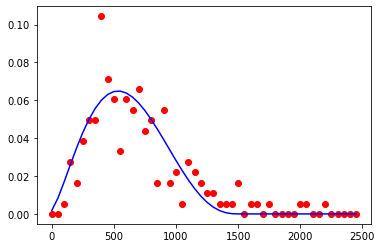

In [9]:
#tdist,distx=getRatioDist(3.5,0.92,720.0,binsize=binsize,nbins=nbins)
fit=fitfunc(xvals,*fitparams)
plt.plot(xvals,yvals,'ro')
plt.plot(xvals,fit,'b-')
#plt.yscale('log')
plt.show()

In [10]:
def arbdev(dist1,nvals):
    dist=dist1/dist1.sum()
    rand=np.random.uniform(size=nvals)
    deviates=np.full(nvals,-1,dtype=int)
    integrals=np.zeros(nvals,dtype=float)
    for i in range(len(dist)):
        for j in range(nvals):
            if(integrals[j]<rand[j]):
                integrals[j]+=dist[i]
            elif(deviates[j]<0):
                deviates[j]=i-1
    for j in range(nvals):
        if(deviates[j]<0):
            deviates[j]=len(dist)-1
    return deviates,rand
    
def simDistribution(dist,ncells):
    deviates,_=arbdev(dist,ncells)
    hist,_=np.histogram(deviates,bins=np.arange(len(dist)+1))
    return hist

#now let's do monte carlo
#these fits are slow so only do 100 for the simulation
def monteCarlo(fitfunc,xvals,yvals,fitparams,sigma,bounds,ncells,niter=10):
    #first get the best fit
    fit=fitfunc(xvals,*fitparams)
    fitscaled=fit*ncells
    allsfitparams=[]
    #now simulate histograms according to this distribution and fit them
    for i in range(niter):
        #at each position the data should follow a poisson distribution
        #sim=np.array([np.random.poisson(fitscaled[i],1)[0] for i in range(len(fitscaled))])
        sim=simDistribution(fit,ncells)
        sim=sim/sim.sum()
        badfit=False
        try:
            sfitparams,_=so.curve_fit(fitfunc,xvals,sim,p0=fitparams,sigma=sigma,bounds=bounds,method='trf',maxfev=100)
        except RuntimeError:
            print('unfittable, skipping simulation')
            badfit=True
        if(not badfit):
            print(sfitparams)
            allsfitparams.append(sfitparams)
    return allsfitparams

In [13]:
#get the monte carlo parameters for wt (183 measured cells)
#warning: this is really slow
mcparams=monteCarlo(fitfunc,xvals,yvals,fitparams,sigma,(lb,ub),int(nwt),niter=50)

[   3.00478083 1536.18478894]
[   2.78638066 1527.45786798]
[   2.80438987 1625.77225043]
[   2.66865126 1548.56841162]
[   2.47631805 1525.07894996]
[   2.59966787 1505.35804811]
[   2.14717186 1556.91559523]
[   2.72013441 1518.52569629]
[   2.67174219 1552.73129743]
[   2.86040955 1534.8923798 ]
[   2.62031353 1403.39867116]
[   2.58397523 1575.39376271]
[   2.97115431 1502.80008282]
[   3.00340982 1568.05467543]
[   2.52567591 1566.94424427]
[   2.66071053 1578.18086556]
[   2.18683175 1447.89444144]
[   2.93046482 1515.30706968]
[   2.58856165 1546.58220955]
[   2.45496066 1488.21980566]
[   2.3416731  1473.37909431]
[   2.1686153  1444.03877874]
[   2.55010949 1413.78390953]
[   2.11301534 1529.35746147]
[   2.97913236 1522.82675099]
[   2.37889701 1573.10592351]
[   2.47325795 1509.16443387]
[   2.54928392 1519.35852445]
[   2.34895422 1504.12408845]
[   2.39295878 1597.79037835]
[   2.56463208 1597.63980499]
[   2.39388061 1518.62623406]
[   2.92218675 1660.05418178]
[   2.8590

In [14]:
#now get the standard deviations which represent the errors
print('parameter avgs:')
print(np.array(mcparams).mean(axis=0))
print('parameter errors:')
print(np.array(mcparams).std(axis=0))

parameter avgs:
[   2.62277113 1524.65125708]
parameter errors:
[ 0.32729836 52.50040283]


In [31]:
#next read in the mutant data
#read in our distribution
#xvals1,yvals1,*_=importpw.plot4read('ppo1_mut_hist_norm_fit.pw2')
mtdf=pd.read_csv('ppo1_mut_hist.csv')
mxvals=mtdf['X'].values
myvals=mtdf['Frequency'].values.astype(float)
nmut=myvals.sum()
myvals/=nmut
mnbins=len(mxvals)
mbinsize=int(mxvals[1]-mxvals[0])
print('nbins: '+str(mnbins))
print('binsize: '+str(mbinsize))

nbins: 29
binsize: 50


In [32]:
#ok--now let's fit the rates
#fix the active/inactive ratio (from fraction of cells with nascents)
mutairatio=0.036
def mutfitfunc(xvals,*params):
    tnbins=len(xvals)
    tbinsize=int(xvals[1]-xvals[0])
    return getRatioDist(params[0],mutairatio,params[1],binsize=tbinsize,nbins=tnbins)[0].astype(float)

In [33]:
mguessparams=[0.5,500.0]
#msigma=np.sqrt(myvals)
#msigma[myvals==0.0]=1.0
msigma=np.ones(len(myvals))
mfitparams,_=so.curve_fit(mutfitfunc,mxvals,myvals,p0=mguessparams,sigma=msigma,bounds=(lb,ub),method='trf')
print('fit params: '+str(mfitparams))

fit params: [1.85325768e-01 5.70655335e+02]


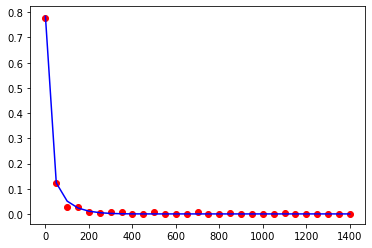

In [34]:
mfit=mutfitfunc(mxvals,*mfitparams)
plt.plot(mxvals,myvals,'ro')
plt.plot(mxvals,mfit,'b-')
#plt.yscale('log')
plt.show()

In [35]:
#get the monte carlo parameters for mutant (339 measured cells)
#warning: this is really slow
mmcparams=monteCarlo(mutfitfunc,mxvals,myvals,mfitparams,msigma,(lb,ub),int(nmut),niter=50)

[1.00000000e-01 3.55994361e+02]
[2.60794939e-01 7.49470516e+02]
[1.03974438e-01 2.98898201e+02]
[1.08627661e-01 3.68292050e+02]
[2.01059320e-01 6.74060081e+02]
[2.07705280e-01 6.96420683e+02]
[1.00000000e-01 3.46229895e+02]
[1.00000000e-01 3.40312484e+02]
[1.00000000e-01 3.99450421e+02]
[1.00000000e-01 3.53938671e+02]
[2.67641195e-01 7.80844400e+02]
[5.52773702e-01 8.51368988e+02]
[3.97152935e-01 7.51983405e+02]
[3.71337747e-01 8.80637271e+02]
[1.94008441e-01 5.24712668e+02]
[3.25485477e-01 7.52592294e+02]
[5.35647210e-01 9.00922402e+02]
[2.94006497e-01 7.05903343e+02]
[1.00000000e-01 4.15216888e+02]
[1.30358937e-01 4.61039937e+02]
[3.91397157e-01 9.11251958e+02]
[2.99913743e-01 8.56646419e+02]
[1.00000000e-01 4.53574252e+02]
[1.44105680e-01 5.54505843e+02]
[2.15811419e-01 6.91099828e+02]
[1.00000000e-01 3.62548274e+02]
[1.03984155e-01 4.34258157e+02]
[1.00000000e-01 3.40631976e+02]
[2.18828109e-01 4.84267069e+02]
[2.00782707e-01 5.34777627e+02]
[2.09899061e-01 6.64075628e+02]
[3.42347

In [36]:
#now get the standard deviations which represent the errors
print('parameter avgs:')
print(np.array(mmcparams).mean(axis=0))
print('parameter errors:')
print(np.array(mmcparams).std(axis=0))

parameter avgs:
[2.31659928e-01 5.98207383e+02]
parameter errors:
[1.23906313e-01 1.86230997e+02]


In [40]:
#need to calculate R^2 values: 1-rss/tss where rss is residual sum of squares and tss is total sum of squares
wtresid=fit-yvals
wtresidnorm=(wtresid*nwt)/(sigma*np.sqrt(nwt))
wtresidnorm[yvals==0]=0.0
wtc2=(wtresidnorm**2).sum()/(nbins-2)
mutresid=mfit-myvals
mutresidnorm=(mutresid*nmut)/np.sqrt(myvals*nmut)
mutresidnorm[myvals==0]=0.0
mutc2=(mutresidnorm**2).sum()/(mnbins-2)
wtrvar=((wtresid*nwt)**2).sum()
wtvar=(((yvals-yvals.mean())*nwt)**2).sum()
mutrvar=((mutresid*nmut)**2).sum()
mutvar=(((myvals-myvals.mean())*nmut)**2).sum()
r2wt=1.0-wtrvar/wtvar
r2mut=1.0-mutrvar/wtrvar
print('R^2 wt and mutant:')
print([r2wt,r2mut])
print('chi^2 wt and mutant:')
print([wtrvar/(nbins-2),mutrvar/(mnbins-2)])

R^2 wt and mutant:
[0.7863082070109018, 0.5423345580994556]
chi^2 wt and mutant:
[4.414160137178139, 3.5914818663136012]


In [41]:
#now calculate the chi squared values if we fix the mutant kprod to the wt value
wtfixkprod=1526
def mutfitfuncfixed(xvals,*params):
    tnbins=len(xvals)
    tbinsize=int(xvals[1]-xvals[0])
    return getRatioDist(params[0],mutairatio,wtfixkprod,binsize=tbinsize,nbins=tnbins)[0].astype(float)

In [42]:
mfguessparams=[0.5]
lb=[0.1]
ub=[10.0]
mffitparams,_=so.curve_fit(mutfitfuncfixed,mxvals,myvals,p0=mfguessparams,sigma=msigma,bounds=(lb,ub),method='trf')
print('fit params fixed: '+str(mffitparams))

fit params fixed: [0.26948246]


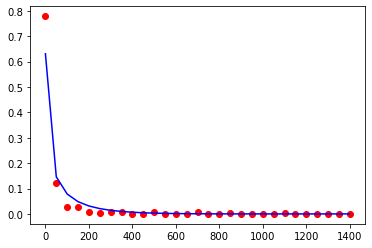

In [43]:
mffit=mutfitfuncfixed(mxvals,*mffitparams)
plt.plot(mxvals,myvals,'ro')
plt.plot(mxvals,mffit,'b-')
plt.show()

In [44]:
mfresid=mffit-myvals
mfresidnorm=(mfresid*nmut)/np.sqrt(nmut*myvals)
mfresidnorm[myvals==0]=0.0
mfc2=(mfresidnorm**2).sum()/(mnbins-1)
mfrvar=((mfresid*nmut)**2).sum()
r2mf=1.0-mfrvar/mutvar
print('r squared (reg, fixed):')
print([r2mut,r2mf])
print('chi squared (reg, fixed):')
print([mutrvar/(mnbins-2),mfrvar/(mnbins-2)])

r squared (reg, fixed):
[0.5423345580994556, 0.9546909008317722]
chi squared (reg, fixed):
[3.5914818663136012, 113.46440020210854]


In [47]:
f=((mfrvar-mutrvar)/mutrvar)/(1/(mnbins-2))
print('F: '+str(f))
p=ss.f.cdf(f,1,mnbins-2)
print('P: '+str(1-p))

F: 826.0013291147236
P: 1.1102230246251565e-16
